In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

### Generate Data and preprocess

In [3]:
from codeE.generate_data import do_gaussianXOR

X, Z = do_gaussianXOR(n=1000,std=0.4)

from sklearn.model_selection import train_test_split
X_train, X_test, Z_train, Z_test = train_test_split(X, Z)
X_train.shape

(2238, 2)

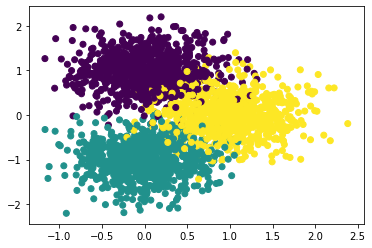

In [4]:
plt.scatter(X_train[:,0],X_train[:,1], c=Z_train)
plt.show()

#### Confusion matrices

In [5]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2450, 2)

### Generate annotations 

In [41]:
Tmax = 100 #annotators number
T_data = 5 #annotations per data
print("proportional to annotator density ",T_data/Tmax )

proportional to annotator density  0.05


In [49]:
B = np.asarray([  #confusion matrices of groups
                [[0.9, 0.1,0.0],
                  [0.2, 0.6, 0.2],
                  [0.1, 0.0, 0.9]] , #group 1 -- quite expert
                 [[0.1, 0.8, 0.1],
                  [0.3, 0.5, 0.2],
                  [0.0, 0.9, 0.1]] #  biased for class 2
                ])
G = np.asarray([0.7, 0.3]) #groups probability: p(g)

In [50]:
from codeE.generate_data import SinteticData

GenerateData = SinteticData()
GenerateData.set_probas(B, G)

y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train, Tmax, T_data)

print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7749287749287749


In [28]:
from codeE.generate_data import SinteticData

#use some matrix that we keep
folder = "./data/synthetic/"
GenerateData = SinteticData(state=folder+"datasim_state.pickle")
GenerateData.set_probas(folder+'/matrix_datasim_normal.csv',folder+'/groups_datasim_normal.csv',
                       asfile=True)

y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data)

print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7130647130647131


In [30]:
GenerateData.save_annotations(y_obs, file_name="datasim_answers", npy=False)

In [12]:
### hacer algo con esto?
real_conf_matrix = GenerateData.conf_matrix.copy()
real_conf_matrix

array([[[0.9, 0.1, 0. ],
        [0.2, 0.6, 0.2],
        [0.1, 0. , 0.9]],

       [[0.1, 0.8, 0.1],
        [0.3, 0.5, 0.2],
        [0. , 0.9, 0.1]]])

### You also can load a fixed synthetic dataset that we build with 3 groups of behavior

In [3]:
folder = "./data/synthetic/"

In [4]:
X_train = np.loadtxt(folder+"/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/datasim_Z_train.csv",dtype='int') 

X_test = np.loadtxt(folder+"/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/datasim_Z_test.csv",dtype='int') 

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [5]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [6]:
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16', delimiter=",")
print("Shape (data,annotators): ",y_obs.shape)
print("not annotation symbol = ",y_obs.min())

Shape (data,annotators):  (2457, 100)
not annotation symbol =  -1


In [33]:
for i in range(y_obs.shape[0]):
    for j in range(y_obs.shape[1]):
        ann = y_obs[i,j]
        if ann != -1:
            plt.scatter(X_train[i,0], X_train[i,1], c=ann)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f3afe81f950> (for post_execute):


KeyboardInterrupt: 

In [31]:
X_train

array([[ 1.05  , -0.3598],
       [ 0.1319, -1.3727],
       [ 0.9518,  0.    ],
       ...,
       [ 1.0885, -0.8416],
       [-0.3208,  0.4494],
       [ 0.0795,  1.4378]])

In [ ]:
    
    
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()

#visualizar gausianas.. los circulos..

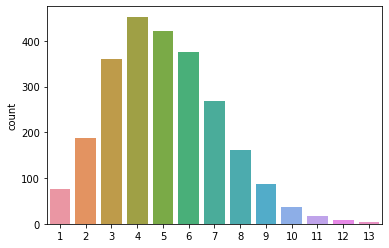

Minimum annotations in a example:  1
Maximum annotations in a example:  13
T data (expected value):  5.03011803011803
Graphics of T weights


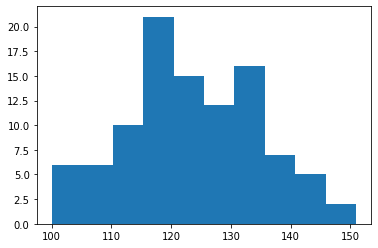

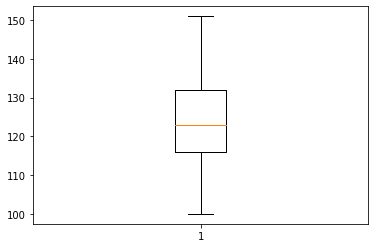

Minimum annotations by an annotator:  100
Maximum annotations by an annotator:  151
Mean annotations by an annotator:  123.59


In [7]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Upper Bound Model -- ideal

In [8]:
#### Delta Convergence criteria
from codeE.learning_models import MLP_Keras, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],16,1,BN=False,drop=0.2)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained Ideal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained Ideal Model, Epochs to converge = 22


In [10]:
from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.9234839234839235
Test accuracy of model = 0.9426129426129426


### Generate Matrix representation of both scenarios

In [11]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (2457, 100, 3)
Global representation shape (N,K)=  (2457, 3)


In [12]:
r_obs

array([[0, 1, 1],
       [0, 3, 1],
       [1, 0, 7],
       ...,
       [0, 0, 2],
       [2, 1, 0],
       [2, 1, 1]], dtype=int32)

### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [13]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (100, 3, 3)


array([[[0.6667, 0.    , 0.3333],
        [0.0952, 0.4048, 0.5   ],
        [0.093 , 0.    , 0.907 ]],

       [[0.6667, 0.    , 0.3333],
        [0.0213, 0.383 , 0.5957],
        [0.0217, 0.    , 0.9783]],

       [[0.6207, 0.    , 0.3793],
        [0.0455, 0.3409, 0.6136],
        [0.1163, 0.    , 0.8837]],

       [[0.5429, 0.    , 0.4571],
        [0.0851, 0.4894, 0.4255],
        [0.087 , 0.    , 0.913 ]],

       [[0.8158, 0.    , 0.1842],
        [0.0185, 0.    , 0.9815],
        [0.6129, 0.    , 0.3871]],

       [[0.6765, 0.    , 0.3235],
        [0.0426, 0.5106, 0.4468],
        [0.0465, 0.    , 0.9535]],

       [[0.8679, 0.    , 0.1321],
        [0.0698, 0.    , 0.9302],
        [0.7174, 0.    , 0.2826]],

       [[0.5185, 0.    , 0.4815],
        [0.1   , 0.425 , 0.475 ],
        [0.05  , 0.    , 0.95  ]],

       [[0.7381, 0.    , 0.2619],
        [0.0196, 0.3922, 0.5882],
        [0.0606, 0.    , 0.9394]],

       [[0.5652, 0.    , 0.4348],
        [0.1064, 0.4255, 0.468

Global matrix shape (K,K)=  (3, 3)


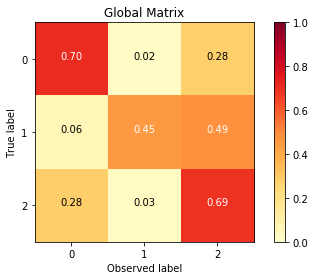

In [14]:
from codeE.utils import generate_Global_conf

confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, title= "Global Matrix")

## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [15]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="global")

mv_soft = label_A.infer(r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')

print("ACC MV on train:",np.mean(mv_hard==Z_train))

mv_hard

ACC MV on train: 0.7130647130647131


array([1, 1, 2, ..., 2, 0, 0])

### Metrics to compare the estimation of confusion matrix

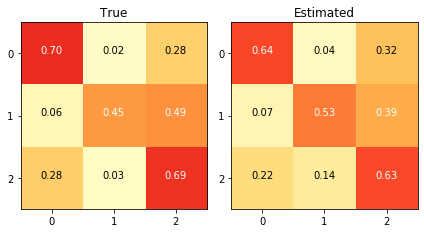

In [17]:
from codeE.utils import generate_confusionM
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotators

from codeE.utils import compare_conf_ma
compare_conf_ma(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

##### Weighted

In [18]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)

print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))
Wmv_soft

ACC MV on train: 0.6886446886446886


array([[0.    , 0.5593, 0.4407],
       [0.    , 0.7319, 0.2681],
       [0.1086, 0.    , 0.8914],
       ...,
       [0.    , 0.    , 1.    ],
       [0.6455, 0.3545, 0.    ],
       [0.4741, 0.2478, 0.278 ]], dtype=float32)

### Dawid and Skene model

In [19]:
from codeE.methods import LabelInf_EM as DS

DS_model = DS(init_Z='softmv') 
DS_model.fit(y_obs_categorical)

Initializing new EM...
Z marginal shape (3,)
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9541.754	
Iter 2/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9199.623	Tol1: 0.03586	Tol2: 0.23181	
Iter 3/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9108.502	Tol1: 0.00990	Tol2: 0.17254	
Iter 4/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9063.231	Tol1: 0.00497	Tol2: 0.15289	
Iter 5/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9036.335	Tol1: 0.00297	Tol2: 0.12852	
Iter 6/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9020.060	Tol1: 0.00180	Tol2: 0.10566	
Iter 7/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9010.213	Tol1: 0.00109	Tol2: 0.08459	
Iter 8/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9004.731	Tol1: 0.00061	Tol2: 0.06920	
Iter 9/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -9001.646	Tol1: 0.00034	Tol2: 0.05633	
Iter 10/50

[-9541.75390625,
 -9199.623046875,
 -9108.501953125,
 -9063.2314453125,
 -9036.3349609375,
 -9020.0595703125,
 -9010.212890625,
 -9004.7314453125,
 -9001.646484375,
 -8999.5048828125,
 -8997.677734375,
 -8996.521484375,
 -8995.8125]

In [20]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ds_labels

p(z) =  [0.3377 0.3294 0.333 ]
ACC D&S on train: 0.8522588522588522


array([[0.002 , 0.9498, 0.0481],
       [0.    , 0.9933, 0.0067],
       [0.004 , 0.0051, 0.991 ],
       ...,
       [0.1463, 0.2293, 0.6244],
       [0.6906, 0.    , 0.3094],
       [0.6398, 0.0888, 0.2714]], dtype=float32)

### Second Phase
train a predictive model over the inference/aggregation label

In [21]:
from codeE.evaluation import accuracy_model

In [22]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 4
Train accuracy of model = 0.49898249898249897
Test accuracy of model = 0.5091575091575091


In [23]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard)
mv_hard_onehot

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [24]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 6
Train accuracy of model = 0.8131868131868132
Test accuracy of model = 0.800976800976801


In [25]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_ds, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, Xstd_test, Z_test))

Trained model over D&S, Epochs to converge = 6
Train accuracy of model = 0.8441188441188441
Test accuracy of model = 0.8620268620268621


## Raykar Model (joint predict model)

In [26]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [27]:
from codeE.methods import ModelInf_EM as Raykar
R_model = Raykar(init_Z="softmv")
args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)

R_model.fit(Xstd_train, y_obs_categorical, runs=20)

Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.58 sec)	logL: -9293.703	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8757.534	Tol1: 0.05769	Tol2: 0.25298	
Iter 3/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8504.939	Tol1: 0.02884	Tol2: 0.18836	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8309.846	Tol1: 0.02294	Tol2: 0.15932	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -8147.449	Tol1: 0.01954	Tol2: 0.13004	
Iter 6/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -8010.063	Tol1: 0.01686	Tol2: 0.10461	
Iter 7/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7897.031	Tol1: 0.01411	Tol2: 0.08302	
Iter 8/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7802.078	Tol1: 0.01202	Tol2: 0.06793	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7726.553	Tol1: 0.00968	Tol2: 0.06146	
Iter 10/50 
M step: done,  E ste

M step: done,  E step: done //  (in 0.05 sec)	logL: -8660.938	Tol1: 0.02125	Tol2: 0.15396	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8489.205	Tol1: 0.01983	Tol2: 0.12950	
Iter 6/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8335.805	Tol1: 0.01807	Tol2: 0.10598	
Iter 7/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8198.590	Tol1: 0.01646	Tol2: 0.08899	
Iter 8/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8076.753	Tol1: 0.01486	Tol2: 0.07482	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7969.616	Tol1: 0.01326	Tol2: 0.06390	
Iter 10/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7873.305	Tol1: 0.01208	Tol2: 0.05562	
Iter 11/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -7792.057	Tol1: 0.01032	Tol2: 0.04368	
Iter 12/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7724.219	Tol1: 0.00871	Tol2: 0.03207	
Iter 13/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7667.333	Tol1: 0.00736	To

M step: done,  E step: done //  (in 0.05 sec)	logL: -8025.666	Tol1: 0.01263	Tol2: 0.06482	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7933.632	Tol1: 0.01147	Tol2: 0.05476	
Iter 10/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7852.292	Tol1: 0.01025	Tol2: 0.04268	
Iter 11/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7778.284	Tol1: 0.00942	Tol2: 0.03393	
Iter 12/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7714.112	Tol1: 0.00825	Tol2: 0.02832	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.48 sec)	logL: -9538.057	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -9102.497	Tol1: 0.04567	Tol2: 0.23734	
Iter 3/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8896.450	Tol1: 0.02264	Tol2: 0.16989	
Iter 4/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8729.477	Tol1: 0.01877	Tol2: 0.15317	
Iter 5/50 
M step: don

M step: done,  E step: done //  (in 0.05 sec)	logL: -8685.934	Tol1: 0.01947	Tol2: 0.15931	
Iter 5/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8528.143	Tol1: 0.01817	Tol2: 0.13584	
Iter 6/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8379.190	Tol1: 0.01747	Tol2: 0.11446	
Iter 7/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8242.535	Tol1: 0.01631	Tol2: 0.09026	
Iter 8/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8116.565	Tol1: 0.01528	Tol2: 0.07629	
Iter 9/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -8003.407	Tol1: 0.01394	Tol2: 0.06640	
Iter 10/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -7907.954	Tol1: 0.01193	Tol2: 0.04753	
Iter 11/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -7826.312	Tol1: 0.01032	Tol2: 0.03522	
Iter 12/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -7758.668	Tol1: 0.00864	Tol2: 0.02824	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (245

([[-9293.703125,
   -8757.5341796875,
   -8504.939453125,
   -8309.845703125,
   -8147.44921875,
   -8010.06298828125,
   -7897.03076171875,
   -7802.078125,
   -7726.552734375,
   -7658.96484375,
   -7607.48876953125],
  [-9340.3388671875,
   -8826.875,
   -8571.685546875,
   -8376.46484375,
   -8219.0556640625,
   -8087.63720703125,
   -7976.86376953125,
   -7882.95703125,
   -7802.7578125,
   -7734.16650390625,
   -7676.3076171875,
   -7625.8349609375,
   -7583.8310546875,
   -7545.3154296875,
   -7513.5361328125],
  [-9488.3125,
   -8975.1044921875,
   -8733.029296875,
   -8551.08984375,
   -8399.548828125,
   -8273.255859375,
   -8163.11669921875,
   -8067.45068359375,
   -7981.7783203125,
   -7905.48681640625,
   -7834.21875],
  [-9313.3095703125,
   -8818.55859375,
   -8559.958984375,
   -8361.912109375,
   -8209.474609375,
   -8090.01953125,
   -7987.89599609375,
   -7898.9912109375,
   -7821.46484375,
   -7751.185546875,
   -7686.90771484375,
   -7632.4765625],
  [-9406.037109

In [28]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.9340659340659341
Test accuracy of model = 0.9499389499389499


## Our Proposed - CMM

In [29]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [30]:
from codeE.methods import ModelInf_EM_CMM as CMM
CMM_model = CMM(M=M_seted) 
args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

CMM_model.fit(Xstd_train, r_obs, runs =20)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -13668.301	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -13106.631	Tol1: 0.04109	Tol2: 0.38282	Tol3: 0.07273	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12816.201	Tol1: 0.02216	Tol2: 0.12099	Tol3: 0.00858	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12596.251	Tol1: 0.01716	Tol2: 0.07890	Tol3: 0.00665	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -12411.424	Tol1: 0.01467	Tol2: 0.05413	Tol3: 0.00590	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -12252.323	Tol1: 0.01282	Tol2: 0.05308	Tol3: 0.00548	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12091.862	Tol1: 0.01310	Tol2: 0.06326	Tol3: 0.00444	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -11924.626	Tol1: 0.01383	Tol2: 0.07625	Tol3: 0.00450	
Iter 

M step: done,  E step: done //  (in 0.47 sec)	logL: -13324.438	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12685.160	Tol1: 0.04798	Tol2: 0.38256	Tol3: 0.10242	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12392.532	Tol1: 0.02307	Tol2: 0.11217	Tol3: 0.02358	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -12179.248	Tol1: 0.01721	Tol2: 0.07329	Tol3: 0.01012	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -11992.374	Tol1: 0.01534	Tol2: 0.06654	Tol3: 0.00914	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11808.163	Tol1: 0.01536	Tol2: 0.07087	Tol3: 0.01041	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11625.180	Tol1: 0.01550	Tol2: 0.08253	Tol3: 0.01263	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11440.602	Tol1: 0.01588	Tol2: 0.09195	Tol3: 0.01464	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11255.229	Tol1: 0.01620	Tol2: 0.10008	Tol3: 0.01704	
Iter 10/

M step: done,  E step: done //  (in 0.05 sec)	logL: -9805.203	Tol1: 0.00050	Tol2: 0.05124	Tol3: 0.00773	
Iter 38/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9800.348	Tol1: 0.00050	Tol2: 0.05306	Tol3: 0.00645	
Iter 39/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9798.353	Tol1: 0.00020	Tol2: 0.05418	Tol3: 0.00627	
Iter 40/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9795.368	Tol1: 0.00030	Tol2: 0.05455	Tol3: 0.00686	
Iter 41/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -9792.162	Tol1: 0.00033	Tol2: 0.05550	Tol3: 0.00658	
Iter 42/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9789.741	Tol1: 0.00025	Tol2: 0.05628	Tol3: 0.00504	
Iter 43/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9788.258	Tol1: 0.00015	Tol2: 0.05606	Tol3: 0.00528	
Iter 44/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9786.435	Tol1: 0.00019	Tol2: 0.05830	Tol3: 0.00555	
Iter 45/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9785.107	Tol1: 0.00

M step: done,  E step: done //  (in 0.06 sec)	logL: -11048.471	Tol1: 0.01932	Tol2: 0.12477	Tol3: 0.00528	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10841.889	Tol1: 0.01870	Tol2: 0.12958	Tol3: 0.00718	
Iter 11/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10660.137	Tol1: 0.01676	Tol2: 0.13418	Tol3: 0.00938	
Iter 12/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10502.277	Tol1: 0.01481	Tol2: 0.13383	Tol3: 0.01052	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10370.575	Tol1: 0.01254	Tol2: 0.13103	Tol3: 0.01211	
Iter 14/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10262.377	Tol1: 0.01043	Tol2: 0.12513	Tol3: 0.01311	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10170.406	Tol1: 0.00896	Tol2: 0.11649	Tol3: 0.01293	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10097.883	Tol1: 0.00713	Tol2: 0.10467	Tol3: 0.01272	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10044.286	T

M step: done,  E step: done //  (in 0.05 sec)	logL: -9825.081	Tol1: 0.00102	Tol2: 0.05672	Tol3: 0.01028	
Iter 49/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9818.968	Tol1: 0.00062	Tol2: 0.05585	Tol3: 0.00884	
Iter 50/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -9815.006	Tol1: 0.00040	Tol2: 0.05119	Tol3: 0.00849	
Finished training!
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.46 sec)	logL: -11951.555	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -11459.072	Tol1: 0.04121	Tol2: 0.38400	Tol3: 0.11627	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11196.292	Tol1: 0.02293	Tol2: 0.14151	Tol3: 0.02803	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10965.358	Tol1: 0.02063	Tol2: 0.13033	Tol3: 0.02005	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10757.919	Tol1: 0.01892	Tol2: 0.13420	Tol3: 0.0209

M step: done,  E step: done //  (in 0.05 sec)	logL: -9870.877	Tol1: 0.00135	Tol2: 0.02813	Tol3: 0.00956	
Finished training!
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.46 sec)	logL: -13146.177	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -12534.604	Tol1: 0.04652	Tol2: 0.36424	Tol3: 0.09249	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -12263.877	Tol1: 0.02160	Tol2: 0.08637	Tol3: 0.00919	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -12043.491	Tol1: 0.01797	Tol2: 0.06500	Tol3: 0.00593	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11830.371	Tol1: 0.01770	Tol2: 0.07313	Tol3: 0.00522	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -11627.206	Tol1: 0.01717	Tol2: 0.08706	Tol3: 0.00509	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11429.579	Tol1: 0.01700	Tol2: 0.09849	Tol3: 0.0049

M step: done,  E step: done //  (in 0.05 sec)	logL: -9889.143	Tol1: 0.00205	Tol2: 0.06667	Tol3: 0.00928	
Iter 20/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9873.810	Tol1: 0.00155	Tol2: 0.06153	Tol3: 0.01001	
Iter 21/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9861.872	Tol1: 0.00121	Tol2: 0.05537	Tol3: 0.00858	
Iter 22/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9850.818	Tol1: 0.00112	Tol2: 0.05333	Tol3: 0.00796	
Iter 23/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9842.627	Tol1: 0.00083	Tol2: 0.05099	Tol3: 0.00723	
Iter 24/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9835.116	Tol1: 0.00076	Tol2: 0.04912	Tol3: 0.00730	
Iter 25/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9828.761	Tol1: 0.00065	Tol2: 0.04508	Tol3: 0.00683	
Iter 26/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9825.749	Tol1: 0.00031	Tol2: 0.03859	Tol3: 0.00678	
Iter 27/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9823.100	Tol1: 0.00

M step: done,  E step: done //  (in 0.05 sec)	logL: -10500.693	Tol1: 0.01807	Tol2: 0.13331	Tol3: 0.02718	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10338.637	Tol1: 0.01543	Tol2: 0.13173	Tol3: 0.02485	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10216.833	Tol1: 0.01178	Tol2: 0.12629	Tol3: 0.02213	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10125.393	Tol1: 0.00895	Tol2: 0.11749	Tol3: 0.01853	
Iter 13/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10059.679	Tol1: 0.00649	Tol2: 0.10536	Tol3: 0.01399	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10007.762	Tol1: 0.00516	Tol2: 0.09134	Tol3: 0.01203	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9967.120	Tol1: 0.00406	Tol2: 0.07357	Tol3: 0.00849	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9938.860	Tol1: 0.00284	Tol2: 0.05404	Tol3: 0.00715	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9917.953	Tol1

M step: done,  E step: done //  (in 0.06 sec)	logL: -11683.292	Tol1: 0.02698	Tol2: 0.30250	Tol3: 0.06446	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11445.540	Tol1: 0.02035	Tol2: 0.09685	Tol3: 0.01802	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -11214.903	Tol1: 0.02015	Tol2: 0.10502	Tol3: 0.01823	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10990.319	Tol1: 0.02003	Tol2: 0.11821	Tol3: 0.02119	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10782.527	Tol1: 0.01891	Tol2: 0.12612	Tol3: 0.02430	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10594.765	Tol1: 0.01741	Tol2: 0.13182	Tol3: 0.02765	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10434.205	Tol1: 0.01515	Tol2: 0.13369	Tol3: 0.02934	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10300.035	Tol1: 0.01286	Tol2: 0.13266	Tol3: 0.03019	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10186.776	Tol1: 0.

M step: done,  E step: done //  (in 0.05 sec)	logL: -10663.165	Tol1: 0.00905	Tol2: 0.09637	Tol3: 0.01367	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10582.557	Tol1: 0.00756	Tol2: 0.09428	Tol3: 0.01345	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10510.299	Tol1: 0.00683	Tol2: 0.09474	Tol3: 0.01363	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10445.765	Tol1: 0.00614	Tol2: 0.09299	Tol3: 0.01395	
Iter 14/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10387.062	Tol1: 0.00562	Tol2: 0.09058	Tol3: 0.01550	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10330.340	Tol1: 0.00546	Tol2: 0.08935	Tol3: 0.01634	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -10278.306	Tol1: 0.00504	Tol2: 0.08722	Tol3: 0.01817	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10230.176	Tol1: 0.00468	Tol2: 0.08498	Tol3: 0.01924	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -10180.720	T

M step: done,  E step: done //  (in 0.06 sec)	logL: -9856.888	Tol1: 0.00087	Tol2: 0.06294	Tol3: 0.00738	
Iter 30/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -9848.243	Tol1: 0.00088	Tol2: 0.06135	Tol3: 0.00766	
Iter 31/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9839.770	Tol1: 0.00086	Tol2: 0.06136	Tol3: 0.00716	
Iter 32/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9832.909	Tol1: 0.00070	Tol2: 0.06213	Tol3: 0.00638	
Iter 33/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -9825.807	Tol1: 0.00072	Tol2: 0.06187	Tol3: 0.00519	
Iter 34/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -9821.294	Tol1: 0.00046	Tol2: 0.06393	Tol3: 0.00487	
Iter 35/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -9817.607	Tol1: 0.00038	Tol2: 0.06562	Tol3: 0.00646	
Iter 36/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9814.244	Tol1: 0.00034	Tol2: 0.06631	Tol3: 0.00660	
Iter 37/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -9810.740	Tol1: 0.00

([array([-13668.3013, -13106.6314, -12816.2007, -12596.2513, -12411.424 ,
         -12252.3233, -12091.8619, -11924.6257, -11752.6322, -11587.4854,
         -11431.2272, -11289.0142, -11163.8586, -11058.5623, -10965.5763,
         -10884.4295, -10813.3326, -10745.6008, -10681.9378, -10621.6283,
         -10560.5039, -10502.3468, -10437.9265, -10378.27  , -10321.3587,
         -10264.6497, -10215.2595, -10166.7715, -10120.6072, -10077.6676,
         -10036.6458, -10002.4224,  -9971.0634,  -9940.7217,  -9916.4472,
          -9893.0732,  -9875.8824,  -9860.5396,  -9847.7366,  -9836.6451,
          -9825.6996]),
  array([-13712.8595, -13048.058 , -12743.7338, -12512.4586]),
  array([-12133.1646, -11768.3508, -11487.0421, -11210.3204, -10959.6572,
         -10733.578 , -10543.6431, -10388.3916, -10255.0944, -10150.4407,
         -10070.9819, -10011.5719,  -9963.8544,  -9926.702 ,  -9902.9402,
          -9880.8008,  -9864.4567,  -9853.0178,  -9844.78  ,  -9834.8289,
          -9828.2676,  -9

In [31]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

Train accuracy of model = 0.9055759055759056
Test accuracy of model = 0.9096459096459096


### Groups found

In [32]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.8222 0.0401 0.1377]


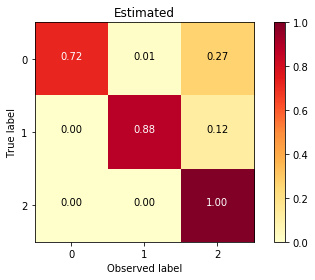

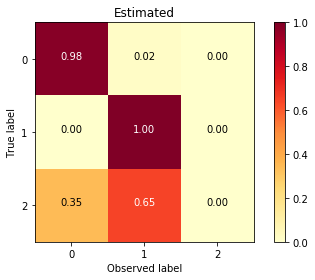

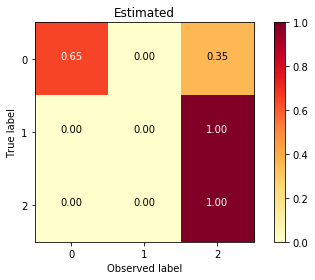

In [33]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Our Proposed - C-MoA

#### Auxiliar representation with variable number of annotations per annotator and identity

In [34]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (2457,)
one-hot vectors of K-dimensions, K= 3


array([array([[0, 1, 0],
       [0, 0, 1]], dtype=int8),
       array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int8),
       array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]], dtype=int8),
       ..., array([[0, 0, 1],
       [0, 0, 1]], dtype=int8),
       array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int8),
       array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=int8)], dtype=object)

In [45]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


#### Fixed annotators representation (non trainable embedding)

In [46]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(len(A_idx_var)):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (100, 3)


In [47]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K,input_length=1, 
                         trainable=False,weights=[A_rep]))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1, 3)              300       
_________________________________________________________________
reshape_2 (Reshape)          (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 30        
Total params: 366
Trainable params: 66
Non-trainable params: 300
_________________________________________________________________


In [48]:
from codeE.methods import ModelInf_EM_CMOA as CMOA
CMOA_model = CMOA(M=M_seted) 
args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)

CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 20) 

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12359, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -24127.987	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -11946.672	Tol1: 0.50486	Tol2: 59267.54596	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -11638.689	Tol1: 0.02578	Tol2: 0.16950	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -11471.892	Tol1: 0.01433	Tol2: 0.07852	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -11280.157	Tol1: 0.01671	Tol2: 0.08424	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -11059.792	Tol1: 0.01954	Tol2: 0.10341	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10814.266	Tol1: 0.02220	Tol2: 0.12536	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10554.510	Tol1: 0.02402	Tol2: 0.14632	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10291.032	Tol1: 0.02496	Tol2: 0.16446	
Iter 10/50
M 

M step: done,  E step: done //  (in 0.12 sec)	logL: -9746.005	Tol1: 0.00049	Tol2: 0.05744	
Iter 40/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9736.525	Tol1: 0.00097	Tol2: 0.05155	
Iter 41/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9730.903	Tol1: 0.00058	Tol2: 0.04966	
Iter 42/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9717.926	Tol1: 0.00133	Tol2: 0.04709	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -9713.335	Tol1: 0.00047	Tol2: 0.04866	
Iter 44/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9712.192	Tol1: 0.00012	Tol2: 0.04420	
Iter 45/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9700.886	Tol1: 0.00116	Tol2: 0.03660	
Iter 46/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9684.738	Tol1: 0.00166	Tol2: 0.03555	
Iter 47/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9666.728	Tol1: 0.00186	Tol2: 0.03763	
Iter 48/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9655.520	Tol1: 0.00116	Tol2: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -9025.536	Tol1: 0.00362	Tol2: 0.14320	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8998.616	Tol1: 0.00298	Tol2: 0.12343	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8976.651	Tol1: 0.00244	Tol2: 0.10810	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8955.591	Tol1: 0.00235	Tol2: 0.09194	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8936.701	Tol1: 0.00211	Tol2: 0.07943	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8919.887	Tol1: 0.00188	Tol2: 0.07424	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8905.306	Tol1: 0.00163	Tol2: 0.07326	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8889.588	Tol1: 0.00176	Tol2: 0.07228	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8877.287	Tol1: 0.00138	Tol2: 0.06885	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8864.077	Tol1: 0.00149	Tol2: 

M step: done,  E step: done //  (in 0.14 sec)	logL: -8603.949	Tol1: 0.01129	Tol2: 0.16418	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8518.524	Tol1: 0.00993	Tol2: 0.16202	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8438.620	Tol1: 0.00938	Tol2: 0.15021	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8373.082	Tol1: 0.00777	Tol2: 0.13236	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8311.521	Tol1: 0.00735	Tol2: 0.11915	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8252.558	Tol1: 0.00709	Tol2: 0.10409	
Iter 29/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8207.006	Tol1: 0.00552	Tol2: 0.08623	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8163.547	Tol1: 0.00530	Tol2: 0.07182	
Iter 31/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -8129.946	Tol1: 0.00412	Tol2: 0.06278	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -8102.821	Tol1: 0.00334	Tol2: 

M step: done,  E step: done //  (in 0.86 sec)	logL: -28990.323	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -11934.176	Tol1: 0.58834	Tol2: 110292.45717	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -11302.954	Tol1: 0.05289	Tol2: 0.21911	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10980.733	Tol1: 0.02851	Tol2: 0.16894	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10660.846	Tol1: 0.02913	Tol2: 0.17832	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10367.977	Tol1: 0.02747	Tol2: 0.20408	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -10119.873	Tol1: 0.02393	Tol2: 0.22654	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -9925.728	Tol1: 0.01918	Tol2: 0.23916	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9773.234	Tol1: 0.01536	Tol2: 0.24336	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9664.544	Tol1: 0.01112	Tol2: 0.24095	
Iter 11/50
M st

M step: done,  E step: done //  (in 0.13 sec)	logL: -8781.053	Tol1: 0.00075	Tol2: 0.06572	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8775.178	Tol1: 0.00067	Tol2: 0.06328	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8769.618	Tol1: 0.00063	Tol2: 0.06054	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8763.298	Tol1: 0.00072	Tol2: 0.06124	
Iter 34/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8757.125	Tol1: 0.00070	Tol2: 0.05965	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8753.476	Tol1: 0.00042	Tol2: 0.06230	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -8746.810	Tol1: 0.00076	Tol2: 0.06082	
Iter 37/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8742.067	Tol1: 0.00054	Tol2: 0.06136	
Iter 38/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8736.277	Tol1: 0.00066	Tol2: 0.05605	
Iter 39/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8732.364	Tol1: 0.00045	Tol2: 

M step: done,  E step: done //  (in 0.12 sec)	logL: -10335.224	Tol1: 0.02407	Tol2: 0.12581	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10104.746	Tol1: 0.02230	Tol2: 0.13566	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9898.096	Tol1: 0.02045	Tol2: 0.14191	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9724.519	Tol1: 0.01754	Tol2: 0.14484	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9581.349	Tol1: 0.01472	Tol2: 0.14408	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9466.832	Tol1: 0.01195	Tol2: 0.14019	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9367.440	Tol1: 0.01050	Tol2: 0.13442	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9286.209	Tol1: 0.00867	Tol2: 0.12567	
Iter 16/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9219.332	Tol1: 0.00720	Tol2: 0.11644	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9163.846	Tol1: 0.00602	Tol2:

M step: done,  E step: done //  (in 0.13 sec)	logL: -9424.574	Tol1: 0.00067	Tol2: 0.05026	
Iter 38/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9414.525	Tol1: 0.00107	Tol2: 0.04604	
Iter 39/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9407.947	Tol1: 0.00070	Tol2: 0.04105	
Iter 40/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9400.816	Tol1: 0.00076	Tol2: 0.03900	
Iter 41/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9389.264	Tol1: 0.00123	Tol2: 0.03559	
Iter 42/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9379.836	Tol1: 0.00100	Tol2: 0.03545	
Iter 43/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9372.416	Tol1: 0.00079	Tol2: 0.03365	
Iter 44/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9366.354	Tol1: 0.00065	Tol2: 0.03281	
Iter 45/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -9363.717	Tol1: 0.00028	Tol2: 0.03007	
Iter 46/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9354.412	Tol1: 0.00099	Tol2: 

M step: done,  E step: done //  (in 0.14 sec)	logL: -8653.061	Tol1: 0.00471	Tol2: 0.04938	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8614.205	Tol1: 0.00449	Tol2: 0.04825	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8578.035	Tol1: 0.00420	Tol2: 0.05006	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8534.248	Tol1: 0.00510	Tol2: 0.05393	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -8502.596	Tol1: 0.00371	Tol2: 0.05828	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8468.935	Tol1: 0.00396	Tol2: 0.05987	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8427.577	Tol1: 0.00488	Tol2: 0.06519	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8396.518	Tol1: 0.00369	Tol2: 0.07655	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8355.239	Tol1: 0.00492	Tol2: 0.07708	
Iter 28/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -8313.217	Tol1: 0.00503	Tol2: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -9550.096	Tol1: 0.00450	Tol2: 0.07305	
Iter 19/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9510.016	Tol1: 0.00420	Tol2: 0.07158	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9462.992	Tol1: 0.00494	Tol2: 0.06999	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9413.830	Tol1: 0.00520	Tol2: 0.06896	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9358.314	Tol1: 0.00590	Tol2: 0.06982	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9296.590	Tol1: 0.00660	Tol2: 0.07175	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9236.587	Tol1: 0.00645	Tol2: 0.06968	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9175.780	Tol1: 0.00658	Tol2: 0.06898	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9116.580	Tol1: 0.00645	Tol2: 0.06396	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9056.659	Tol1: 0.00657	Tol2: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -9300.067	Tol1: 0.00765	Tol2: 0.10947	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9224.728	Tol1: 0.00810	Tol2: 0.10705	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -9149.220	Tol1: 0.00819	Tol2: 0.10225	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -9076.281	Tol1: 0.00797	Tol2: 0.09152	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9004.768	Tol1: 0.00788	Tol2: 0.08866	
Iter 24/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -8937.399	Tol1: 0.00748	Tol2: 0.08946	
Iter 25/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8875.629	Tol1: 0.00691	Tol2: 0.08527	
Iter 26/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8814.599	Tol1: 0.00688	Tol2: 0.08389	
Iter 27/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8761.407	Tol1: 0.00603	Tol2: 0.08147	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -8715.090	Tol1: 0.00529	Tol2: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -9136.912	Tol1: 0.00130	Tol2: 0.05390	
Iter 49/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9119.827	Tol1: 0.00187	Tol2: 0.05703	
Iter 50/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -9110.659	Tol1: 0.00101	Tol2: 0.05360	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 3, 3)
Q estimate:  (12359, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.92 sec)	logL: -13676.835	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -11343.185	Tol1: 0.17063	Tol2: 0.45568	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -11009.220	Tol1: 0.02944	Tol2: 0.12626	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10723.100	Tol1: 0.02599	Tol2: 0.11011	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -10431.726	Tol1: 0.02717	Tol2: 0.12192	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -10154.144	Tol1: 0.02661	Tol2: 0.13475	
Iter 7/50

([array([-24127.9874, -11946.6716, -11638.6887, -11471.8923, -11280.1571,
         -11059.7921, -10814.2657, -10554.5104, -10291.0323, -10032.9205,
          -9804.3409,  -9616.1461,  -9473.9865,  -9362.4096,  -9277.8078,
          -9214.2091,  -9163.5185,  -9121.6675,  -9085.1467,  -9061.1954,
          -9037.5423,  -9018.7056,  -8999.4054,  -8983.4179,  -8969.5206,
          -8955.0636,  -8942.0999,  -8928.9974,  -8916.2322,  -8905.0332,
          -8894.974 ,  -8883.8063,  -8875.4927,  -8866.9774,  -8857.3999,
          -8849.3517,  -8840.806 ,  -8833.5525,  -8824.6729,  -8817.6268]),
  array([-15242.4121, -12123.0748, -11778.6602, -11508.912 , -11267.3838,
         -11057.1627, -10880.1097, -10735.8512, -10611.1966, -10504.6413,
         -10402.9327, -10314.7001, -10237.3235, -10170.7081, -10114.0182,
         -10064.625 , -10024.2804,  -9990.1491,  -9962.2081,  -9936.1161,
          -9914.4008,  -9894.0796,  -9877.4231,  -9860.1039,  -9847.7019,
          -9833.3472,  -9822.3417,  

In [49]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

Train accuracy of model = 0.9251119251119251
Test accuracy of model = 0.9474969474969475


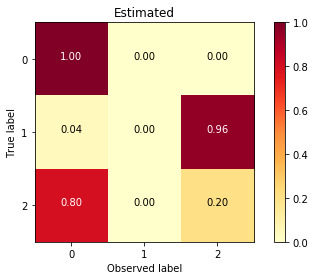

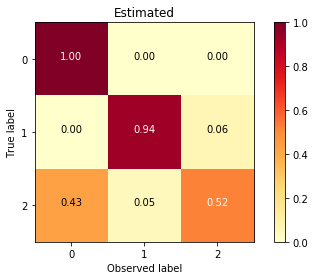

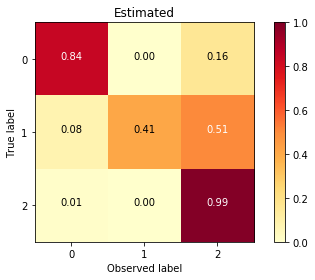

In [50]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

In [51]:
CMOA_model.get_groupmodel().get_weights()[0] #annotator representations

array([[40., 17., 76.],
       [36., 18., 90.],
       [43., 15., 87.],
       [27., 23., 78.],
       [51.,  0., 72.],
       [27., 24., 73.],
       [82.,  0., 60.],
       [20., 17., 70.],
       [34., 20., 72.],
       [35., 20., 73.],
       [30., 13., 62.],
       [32., 17., 66.],
       [58., 53., 28.],
       [45., 38., 20.],
       [28., 14., 74.],
       [25., 10., 85.],
       [26., 19., 72.],
       [53., 51., 23.],
       [28., 21., 67.],
       [44., 23., 72.],
       [68.,  0., 60.],
       [38., 18., 82.],
       [23., 21., 88.],
       [32., 18., 60.],
       [36., 14., 68.],
       [27., 18., 83.],
       [30., 12., 81.],
       [75.,  0., 50.],
       [26., 21., 76.],
       [21., 15., 64.],
       [46., 22., 64.],
       [37., 14., 76.],
       [52., 57., 30.],
       [44., 54., 23.],
       [29., 24., 82.],
       [29., 15., 89.],
       [57.,  0., 53.],
       [23., 22., 72.],
       [57.,  0., 53.],
       [49., 46., 22.],
       [31., 14., 74.],
       [35., 16.

### mostrar el decaimeitno en performance al aumentar el numero de anotadoras